# Assignment Part 2: Neural Net Template

This file contains the template code for the Neural Net with hidden layers.

### Artificial Neural Net Class

In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.special import expit

class ANN:
    def __init__(self, input_size, output_size,lr_scheduler,
                 hidden_layers=[128,64], 
                 max_iterations=20, 
                 learning_rate=0.01,
                 activation='sig',
                 momentum=0,
                 batch_size=512,
                 multiclass = True):
        self.hidden_layers = hidden_layers # List of the number of nodes in each hidden layers 
        # TO-DO:
        self.input_size = input_size 
        self.output_size = output_size # The number of nodes in the output layer
        self.max_iter = max_iterations # Total number of epoch
        self.learning_rate = learning_rate 
        self.activation = activation # Activation function in the hidden layer
        self.momentum=momentum # Applying momentum in the learning process
        self.lr_scheduler = lr_scheduler  # Example scheduler with decay every 5 epochs
        self.batch_size = batch_size # Determining the batch size for the mini batch training
        self.multiclass = multiclass
        # Determining the activation function in the output layer
        if multiclass: 
            last_layer = 'softmax'
        else: last_layer = 'sig'
        # List of activation function in order within the model    
        self.layers_activation = [activation for _ in range(len(self.hidden_layers))] + [last_layer]
        # TO-DO:
        # Initiate Weights
        self.weights=[]
        # As we will be making multi-layer neural network so we use Xavier initialization to alleviate vanishing/exploding gradient problem
        for layer in range(len(hidden_layers)+1):
            # The weight of the input layer x first hidden layer
            if layer == 0:
                input_nodes= input_size
                output_nodes=hidden_layers[0]
            else: 
            # Between the hidden layers
                input_nodes=hidden_layers[layer-1]
                if layer < len(hidden_layers):
                    output_nodes=hidden_layers[layer]
                elif layer == len(hidden_layers):
                    output_nodes=output_size
            # Calculate variance
            variance=2/(input_nodes+output_nodes)
            # Initialize weight 
            np.random.seed(42)
            layer_weight=np.random.normal(loc=0, scale=np.sqrt(variance), 
                                   size=(input_nodes,output_nodes))
            self.weights.append(layer_weight)       
            
        # Initiate bias
        self.biases=[np.zeros(hidden_layers[0])]   
        for i in range(1, len(hidden_layers)):
            self.biases.append(np.zeros(hidden_layers[i]))
        self.biases.append(np.zeros(output_size))

        #Initialize momentum for weights
        self.momentum_weights=[np.zeros_like(w) for w in self.weights]
        self.momentum_biases=[np.zeros_like(b) for b in self.biases]
        
    def activate_sigmoid(self, a):
        # TO-DO: implement sigmoid
#        return expit(a) For some scenario, the np.exp may not be enough to perform calculation and we can use expit instrad
        return 1 / (1 + np.exp(-a))

    def derv_sigmoid(self,a):
        return a*(1-a)

    def activate_relu(self, a):
        return np.maximum(0,a)
    
    def derv_relu(self,a):
        return np.where(a>0,1,0)
    
    def activate_softmax(self, a):
        exp_a=np.exp(a-np.max(a,axis=-1, keepdims=True))
        return exp_a/np.sum(exp_a, axis=-1,keepdims=True)
    
    # Based on the architecture of the model to apply the correct activation function
    def activation_func(self, activate):
        if activate == 'sig':
            return self.activate_sigmoid
        elif activate == 'relu':
            return self.activate_relu
        elif activate == 'softmax':
            return self.activate_softmax
    # Applying the derivative during the back propagation, since softmax is a special case so we only include sigmoid and relu
    def derv_func(self, derv):
        if derv == 'sig':
            return self.derv_sigmoid
        elif derv == 'relu':
            return self.derv_relu
        
    #=========================================#
    # Performs feed-forward prediction on     #
    # batch of inputs.                        #
    #=========================================#
    def do_predict(self, a):
        # TO-DO:
        # Saving the input as the first values in the activation
        self.activations=[a]
        # Loop through the layers and perform matrices multiplication
        for i in range(len(self.weights)):
            z=np.matmul(self.activations[-1], self.weights[i]) #+ self.biases[i]            
            activation=self.activation_func(self.layers_activation[i])
            # Adding the layer output
            self.activations.append(activation(z))
        
#Since we will be doing a multi-class classificaiton with 10 labels so we will use cross entropy for loss calculation
    def cross_entropy_loss(self, labels,pred):
        return -np.sum(labels * np.log(pred)) / len(labels)
        
    def do_backward(self,training_data, labels):
         #Compute gradients for output layer
        self.do_predict(training_data)
        errors = self.activations[-1] - labels
         # depend on the task being binary or multi-class classification we use either softmax or sigmoid
        if self.multiclass:
            self.deltas=[errors]
        else:
            self.deltas= [errors*self.derv_sigmoid(self.activations[-1])]
        
        # Back propagate through the hidden layers
        for i in range(len(self.weights) - 1, 0, -1):
            derv_activation=self.derv_func(self.activation)
            delta=np.matmul(self.deltas[0], self.weights[i].T)*derv_activation(self.activations[i])
            self.deltas.insert(0,delta)
             
        # Update weights
        for i in range(len(self.weights)):
            # Compute gradients
            weight_grad=np.matmul(self.activations[i].T,self.deltas[i])/len(training_data)
            bias_grad=np.mean(self.deltas[i],axis=0)
            # Update momentum 
            self.momentum_weights[i]=self.momentum*self.momentum_weights[i]+(1 - self.momentum)*weight_grad
            self.momentum_biases[i]=self.momentum*self.momentum_biases[i]+(1 - self.momentum)*bias_grad
            
            # Update weights and bias
            self.weights[i] -= self.learning_rate*self.momentum_weights[i]
            self.biases[i] -= self.learning_rate*self.momentum_biases[i]
 
    #===============================#
    # Trains the net using labelled #
    # training data.                #
    #===============================#
    
    def do_train(self, training_data, labels):
        assert len(training_data) == len(labels)
        # Check for number of classes
        num_classes = np.max(labels) + 1
        # Apply One-hot encoding
        labels = np.eye(num_classes)[labels]

        # Start measuring training time
        start_time = time.time()
        for iter in range(self.max_iter):
            # Shuffle the data at the beginning of each iteration
            indices = np.arange(len(training_data))
            np.random.shuffle(indices)
            shuffled_data = training_data[indices]
            shuffled_labels = labels[indices]

            # Determine number of batches needed
            num_samples = len(shuffled_data)
            num_batches = num_samples // self.batch_size

            # Split data into mini-batches
            data_batches = [shuffled_data[i * self.batch_size: (i + 1) * self.batch_size] for i in range(num_batches)]
            label_batches = [shuffled_labels[i * self.batch_size: (i + 1) * self.batch_size] for i in range(num_batches)]

            # Updating the learning rate
            self.learning_rate = self.lr_scheduler.step(iter)
            for i in range(num_batches):
                self.do_backward(data_batches[i], label_batches[i])
            # Printing out the result of the training process every 5 iterations
            if (iter + 1) % 5 == 0:
                self.do_predict(training_data)
                # Calculate the current loss values
                loss = self.cross_entropy_loss(labels, self.activations[-1])
                print(f'Iteration: {iter + 1}/{self.max_iter}, Loss: {loss:.4f}, Learning Rate: {self.learning_rate}')
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Total training time: {training_time} seconds")
        return training_time
                
    def test(self, testing_data, labels):
        assert len(testing_data) == len(labels)
        #TO-DO:
        self.do_predict(testing_data)
        pred=self.activations[-1]
        # Convert probabilities to discrete class labels
        pred_labels=np.argmax(pred, axis=1) 
        
        # Adapting the code for both binary and multi-class classification
        if self.multiclass:
            average = 'weighted'
        else: # in case of binary classification
            average = None
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(labels, pred_labels)
        # Visualized the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
        plt.title('Confusion Matrix')
        plt.show()
        # Calculate the metrics
        sklearn_acc=accuracy_score(labels,pred_labels)
        sklearn_precision=precision_score(labels,pred_labels, average=average)
        sklearn_recall=recall_score(labels,pred_labels, average=average)
        sklearn_f1=f1_score(labels,pred_labels, average=average)
        
        if not self.multiclass:
            sklearn_precision = sklearn_precision[0]
            sklearn_recall = sklearn_recall[0]
            sklearn_f1 = sklearn_f1[0]
        
        print("Accuracy:\t"+str(sklearn_acc))
        print("Precision:\t"+str(sklearn_precision))
        print("Recall:\t"+str(sklearn_recall))
        print("F1 score:\t"+str(sklearn_f1))
        return sklearn_acc,sklearn_precision,sklearn_recall,sklearn_f1

In [4]:
# Create the learning scheduler to gradually reduce the size of the learning rate
class LearningRateScheduler:
    def __init__(self, initial_lr, decay_factor, decay_interval):
        self.initial_lr=initial_lr
        self.decay_factor=decay_factor # How much the learning rate will be reduce
        self.decay_interval=decay_interval # The interval to reduce the learning rate by
        self.lr=initial_lr

    def step(self, epoch):
        if epoch % self.decay_interval == 0:
            self.lr *= self.decay_factor
        return self.lr

### Main method

The following cell(s) should complete parts 2.1 to 2.5.

## 2.1. Complete the implementation of the ANN class
## 2.2. Complete the initialisation of the neural net
## 2.3. Complete the training implementation 
## 2.4. Complete the testing implementation

In [ ]:
# TO-DO load training data
# TO-DO load testing data

#Adding columns
pixel_col=['pixel'+str(i) for i in range(1,785)]
class_col=['class']

# Reading each files into df
classes=pd.read_csv('classes.csv')
train_df=pd.read_csv('train.csv', header=None, names=class_col+pixel_col)
test_df=pd.read_csv('test.csv', header=None, names=class_col+pixel_col)

In [23]:
# Splitting the data
y_train=np.asarray(train_df['class'])
X_train=np.asarray(train_df.drop(['class'], axis=1))/255
y_test=np.asarray(test_df['class'])
X_test=np.asarray(test_df.drop(['class'], axis=1))/255

# Creating the dataset just for ship label
y_ship_train=np.where(y_train==7,1,0)
y_ship_test=np.where(y_test==7,1,0)

# Apply One-hot encoding 
num_classes=np.max(y_train) +1
y_train_encoded=np.eye(num_classes)[y_train]
y_test_encoded=np.eye(num_classes)[y_test]

KeyboardInterrupt: 

In [5]:
# In case of binary classfication, we apply undersampling so the model can learn from both classes    
def undersampling(X, y):
    #Find indices of each class
    # in the process of relabeling for binary classificaiton, y==1 will always represent the minority class 
    indices_minority= np.where(y== 1)[0]
    indices_majority= np.where(y== 0)[0]
    #count images in the minority class
    num_minority=len(indices_minority)
    #Randomly select the same number of images in the majority 
    np.random.seed(42)
    np.random.shuffle(indices_majority)
    indices_majority_undersampled=indices_majority[:num_minority]
    # Combine all indices of minority + selected majority
    indices_undersampled=np.concatenate((indices_minority,indices_majority_undersampled))
    
    # save the data
    X_undersampled = X[indices_undersampled] 
    y_undersampled = y[indices_undersampled]
    
    # Shuffle the data
    shuffle_indices = np.arange(len(y_undersampled))
    np.random.shuffle(shuffle_indices)
    X_undersampled = X_undersampled[shuffle_indices]
    y_undersampled = y_undersampled[shuffle_indices]
    return X_undersampled, y_undersampled
X_train_undersampled , y_ship_train_undersampled = undersampling(X_train,y_ship_train)

### Testing out the binary classification

For the binary classification task on the ship images, compare to the online learning sigmoid perceptron that got **0.54** F1 score, a simple neural network outperform it with F1 score at **0.8716**


Iteration: 5/50, Loss: 0.6869,Learning Rate: 0.08000000000000002
Iteration: 10/50, Loss: 0.6818,Learning Rate: 0.06400000000000002
Iteration: 15/50, Loss: 0.6769,Learning Rate: 0.051200000000000016
Iteration: 20/50, Loss: 0.6722,Learning Rate: 0.04096000000000002
Iteration: 25/50, Loss: 0.6679,Learning Rate: 0.03276800000000001
Iteration: 30/50, Loss: 0.6640,Learning Rate: 0.026214400000000013
Iteration: 35/50, Loss: 0.6605,Learning Rate: 0.02097152000000001
Iteration: 40/50, Loss: 0.6575,Learning Rate: 0.016777216000000008
Iteration: 45/50, Loss: 0.6550,Learning Rate: 0.013421772800000007
Iteration: 50/50, Loss: 0.6529,Learning Rate: 0.010737418240000006
Total training time: 5.54133415222168 seconds


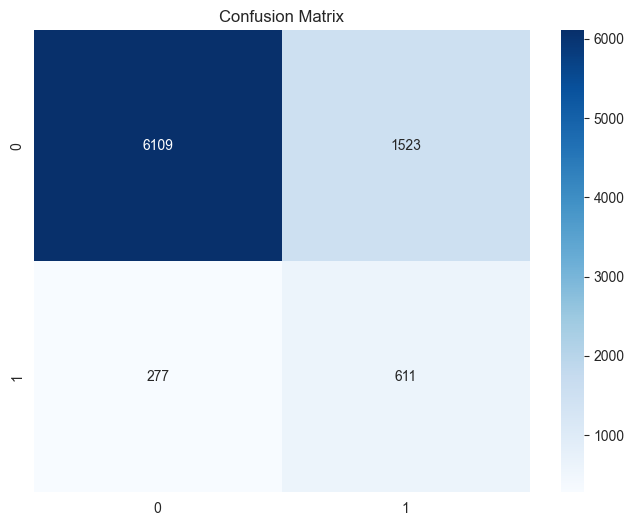

Accuracy:	0.7887323943661971
Precision:	0.95662386470404
Recall:	0.8004454926624738
F1 score:	0.8715936652874875


In [6]:
hidden_layers=[128,32]
max_iterations=50
learning_rate=0.1
momentum=0 # With this set to 0, we essentially not using momentum in the current code
decay_factor = 0.8 # How much the learning rate will be reduce by after every decay_interval 
decay_interval = 5   # The interval after which the learning rate will be reduce  
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)

# TO-DO create a net
NN_test=ANN(X_train.shape[1],2, 
                hidden_layers=hidden_layers, 
                max_iterations=max_iterations, 
                learning_rate=learning_rate,
                momentum=momentum,
                lr_scheduler= lr_scheduler,
                activation='sig',
            multiclass=False
              )

# TO-DO call train
NN_test.do_train(X_train_undersampled,y_ship_train_undersampled)
# TO-DO call test
res_binary = NN_test.test(X_test, y_ship_test)

In [7]:
# inputing the result from the perceptron training process
model_results = []
training_time= 40.48753547668457
acc= 0.34237089201877935
pre =	0.43860740018725
recall=	0.34237089201877935
f1=	0.3336873811231393

res = {"activation": 'sigmoid',
    "hidden_layer": 'multi_perceptron', 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

Iteration: 5/50, Loss: 2.0501,Learning Rate: 0.06999999999999999
Iteration: 10/50, Loss: 1.8827,Learning Rate: 0.048999999999999995
Iteration: 15/50, Loss: 1.8185,Learning Rate: 0.0343
Iteration: 20/50, Loss: 1.7861,Learning Rate: 0.024009999999999997
Iteration: 25/50, Loss: 1.7654,Learning Rate: 0.016806999999999996
Iteration: 30/50, Loss: 1.7514,Learning Rate: 0.011764899999999997
Iteration: 35/50, Loss: 1.7418,Learning Rate: 0.008235429999999997
Iteration: 40/50, Loss: 1.7352,Learning Rate: 0.005764800999999997
Iteration: 45/50, Loss: 1.7307,Learning Rate: 0.004035360699999998
Iteration: 50/50, Loss: 1.7275,Learning Rate: 0.0028247524899999983
Total training time: 31.466909646987915 seconds


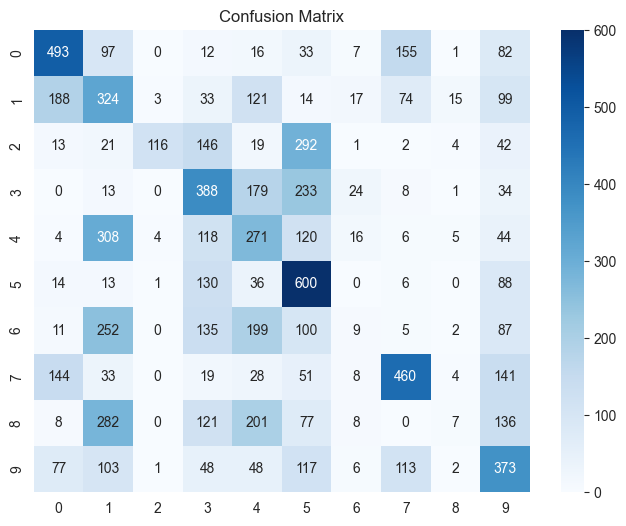

Accuracy:	0.356924882629108
Precision:	0.36580015205356137
Recall:	0.356924882629108
F1 score:	0.3231406864329903


In [8]:
hidden_layers=[128,64]
max_iterations=50
learning_rate=0.1
momentum=0 # With this set to 0, we essentially not using momentum in the current code
decay_factor = 0.7 # How much the learning rate will be reduce by after every decay_interval 
decay_interval = 5  # The interval after which the learning rate will be reduce  
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)
activation = 'sig'
# TO-DO create a net
NN_sigmoid_2layers_light=ANN(X_train.shape[1],10, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation)
# TO-DO call train
training_time = NN_sigmoid_2layers_light.do_train(X_train,y_train)
# TO-DO call test
acc, pre,recall,f1 = NN_sigmoid_2layers_light.test(X_test, y_test)

res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

Iteration: 5/50, Loss: 1.9948,Learning Rate: 0.06999999999999999
Iteration: 10/50, Loss: 1.8420,Learning Rate: 0.048999999999999995
Iteration: 15/50, Loss: 1.7953,Learning Rate: 0.0343
Iteration: 20/50, Loss: 1.7662,Learning Rate: 0.024009999999999997
Iteration: 25/50, Loss: 1.7455,Learning Rate: 0.016806999999999996
Iteration: 30/50, Loss: 1.7309,Learning Rate: 0.011764899999999997
Iteration: 35/50, Loss: 1.7207,Learning Rate: 0.008235429999999997
Iteration: 40/50, Loss: 1.7138,Learning Rate: 0.005764800999999997
Iteration: 45/50, Loss: 1.7089,Learning Rate: 0.004035360699999998
Iteration: 50/50, Loss: 1.7056,Learning Rate: 0.0028247524899999983
Total training time: 83.1648530960083 seconds


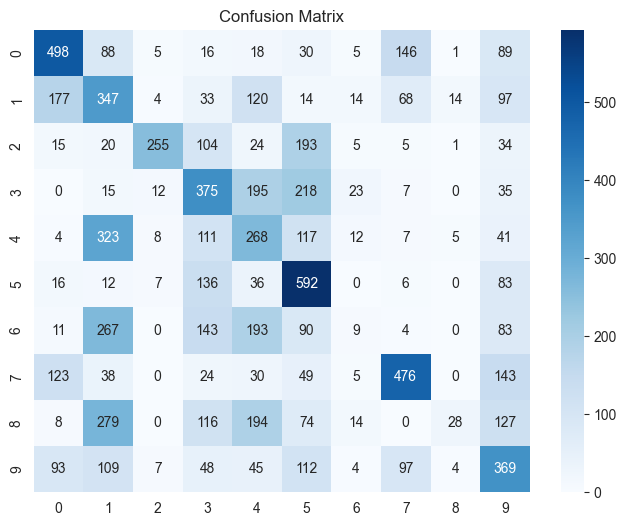

Accuracy:	0.37758215962441316
Precision:	0.4041054794367635
Recall:	0.37758215962441316
F1 score:	0.3521915487266234


In [9]:
hidden_layers=[256,128]
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)

# TO-DO create a net
NN_sigmoid_2layers_extensive=ANN(X_train.shape[1],10, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation)
# TO-DO call train
training_time = NN_sigmoid_2layers_extensive.do_train(X_train,y_train)
# TO-DO call test
acc, pre,recall,f1 =NN_sigmoid_2layers_extensive.test(X_test, y_test)
# Saving the training results
res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

In [10]:
pd.DataFrame(model_results)

,activation,hidden_layer,accuracy,precision,recall,f1_score,training_time
0,sigmoid,multi_perceptron,0.342371,0.438607,0.342371,0.333687,40.487535
1,sig,"[128, 64]",0.356925,0.365800,0.356925,0.323141,31.466910
2,sig,"[256, 128]",0.377582,0.404105,0.377582,0.352192,83.164853


(1) Compare to the single-layer one-versus-all multi-perceptron, with accuracy at **0.34**, F1 score at **0.333**, a light neural net (with hidden layer at [128,64]) using sigmoid achieved accuracy at **0.357**, F1 score at **0.323**, and a more exhaustive neural network (hidden layers at [256,128]) achieved accuracy at **0.3777** and F1 score at **0.352**

(2) In this neural network, for the initial weight, instead of just using all zeroes at the weight initialization, I applied **Xavier initialization**, which sampled the weight from a normal distribution with variance depends on total input and output. This initialization method help mitigate the vanishing and exploding gradient problems. I also use a **Learning Rate Scheduler** to slowly reduce the size of my learning rate as my model slowly converge. As for batch size, I set it up at 512 images per batch, which is a result of an iterative process to balance between training speed and accuracy metrics.

(3) Compare to the multiple perceptron, which took a total of **40.5** seconds to train, the light neural network only took around **32** seconds to train *on the same hardware*, and the exhaustive neural net took **82** seconds. 

(4) In both neural network, most of the learning happened in the first **15 to 20 iterations**, which is similar to the single-layer perceptron which converge quickly in the first 15 iterations. There also seem to be a hard limit when using sigmoid as even at extremely high nodes count on the hidden layers, at [512,256], the model does not achieve F1 score better than **0.45** 

## 2.5. Implement the rectifier activation function

Iteration: 5/50, Loss: 1.5919,Learning Rate: 0.06999999999999999
Iteration: 10/50, Loss: 1.3768,Learning Rate: 0.048999999999999995
Iteration: 15/50, Loss: 1.3228,Learning Rate: 0.0343
Iteration: 20/50, Loss: 1.2131,Learning Rate: 0.024009999999999997
Iteration: 25/50, Loss: 1.1661,Learning Rate: 0.016806999999999996
Iteration: 30/50, Loss: 1.1387,Learning Rate: 0.011764899999999997
Iteration: 35/50, Loss: 1.1192,Learning Rate: 0.008235429999999997
Iteration: 40/50, Loss: 1.1051,Learning Rate: 0.005764800999999997
Iteration: 45/50, Loss: 1.0951,Learning Rate: 0.004035360699999998
Iteration: 50/50, Loss: 1.0885,Learning Rate: 0.0028247524899999983
Total training time: 27.720701456069946 seconds


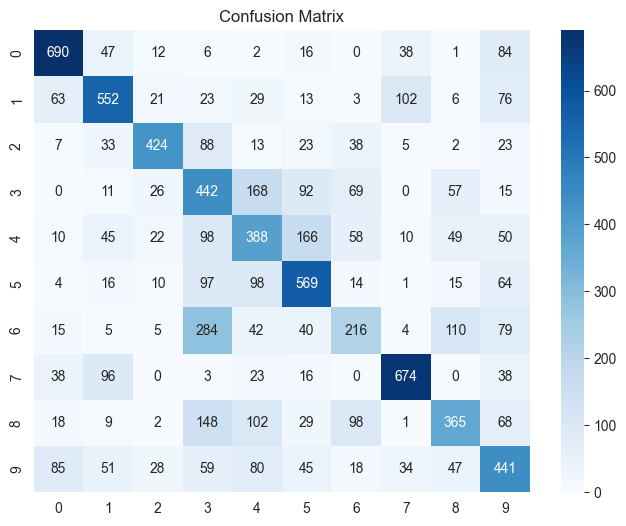

Accuracy:	0.5588028169014084
Precision:	0.5669181292464961
Recall:	0.5588028169014084
F1 score:	0.558430002117062


In [11]:
hidden_layers =[128,64]
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)
activation = 'relu'
NN_relu_2layers_light=ANN(X_train.shape[1],10, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation)
# TO-DO call train
training_time = NN_relu_2layers_light.do_train(X_train,y_train)
# TO-DO call test
acc, pre,recall,f1 = NN_relu_2layers_light.test(X_test, y_test)
# Saving the training results
res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

Iteration: 5/50, Loss: 1.7122,Learning Rate: 0.06999999999999999
Iteration: 10/50, Loss: 1.5000,Learning Rate: 0.048999999999999995
Iteration: 15/50, Loss: 1.3564,Learning Rate: 0.0343
Iteration: 20/50, Loss: 1.2863,Learning Rate: 0.024009999999999997
Iteration: 25/50, Loss: 1.2106,Learning Rate: 0.016806999999999996
Iteration: 30/50, Loss: 1.1782,Learning Rate: 0.011764899999999997
Iteration: 35/50, Loss: 1.1447,Learning Rate: 0.008235429999999997
Iteration: 40/50, Loss: 1.1197,Learning Rate: 0.005764800999999997
Iteration: 45/50, Loss: 1.0981,Learning Rate: 0.004035360699999998
Iteration: 50/50, Loss: 1.0834,Learning Rate: 0.0028247524899999983
Total training time: 30.601184844970703 seconds


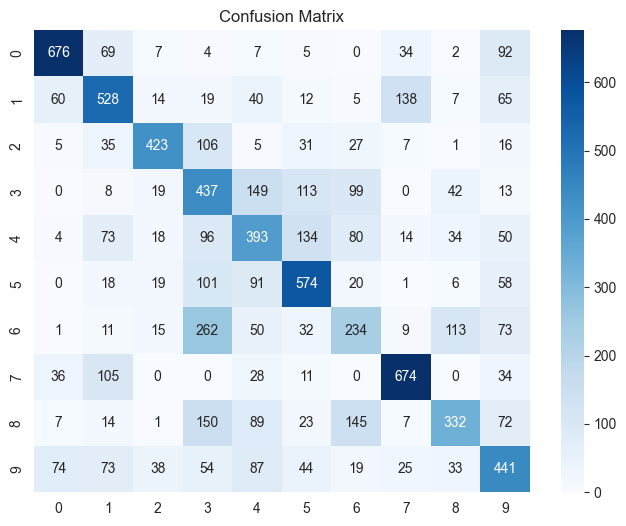

Accuracy:	0.5530516431924882
Precision:	0.5618594018827203
Recall:	0.5530516431924882
F1 score:	0.5533854511823111


In [12]:
hidden_layers=[128,64,32,16]
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)

NN_relu_4layers_light=ANN(X_train.shape[1],10, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation)
# TO-DO call train
training_time = NN_relu_4layers_light.do_train(X_train,y_train)
# TO-DO call test
acc, pre,recall,f1 =NN_relu_4layers_light.test(X_test, y_test)

# Saving the training results
res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

Iteration: 5/50, Loss: 1.6974,Learning Rate: 0.06999999999999999
Iteration: 10/50, Loss: 1.4009,Learning Rate: 0.048999999999999995
Iteration: 15/50, Loss: 1.2503,Learning Rate: 0.0343
Iteration: 20/50, Loss: 1.1592,Learning Rate: 0.024009999999999997
Iteration: 25/50, Loss: 1.1024,Learning Rate: 0.016806999999999996
Iteration: 30/50, Loss: 1.0096,Learning Rate: 0.011764899999999997
Iteration: 35/50, Loss: 0.9739,Learning Rate: 0.008235429999999997
Iteration: 40/50, Loss: 0.9455,Learning Rate: 0.005764800999999997
Iteration: 45/50, Loss: 0.9261,Learning Rate: 0.004035360699999998
Iteration: 50/50, Loss: 0.9123,Learning Rate: 0.0028247524899999983
Total training time: 81.83425235748291 seconds


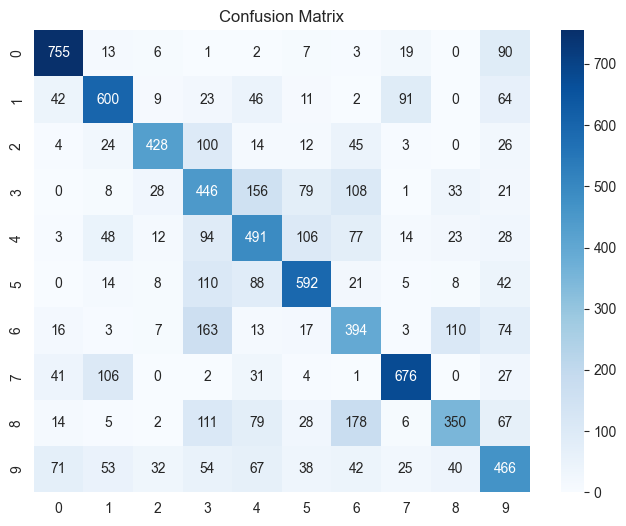

Accuracy:	0.610093896713615
Precision:	0.6213874900739735
Recall:	0.610093896713615
F1 score:	0.612216885168766


In [13]:
hidden_layers=[256,128,64,32]
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)

NN_relu_4layers=ANN(X_train.shape[1],10, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation)
# TO-DO call train
training_time = NN_relu_4layers.do_train(X_train,y_train)
# TO-DO call test
acc, pre,recall,f1 =NN_relu_4layers.test(X_test, y_test)

# Saving the training results
res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

Iteration: 5/50, Loss: 2.2978,Learning Rate: 0.06999999999999999
Iteration: 10/50, Loss: 2.2966,Learning Rate: 0.048999999999999995
Iteration: 15/50, Loss: 2.2955,Learning Rate: 0.0343
Iteration: 20/50, Loss: 2.2945,Learning Rate: 0.024009999999999997
Iteration: 25/50, Loss: 2.2937,Learning Rate: 0.016806999999999996
Iteration: 30/50, Loss: 2.2929,Learning Rate: 0.011764899999999997
Iteration: 35/50, Loss: 2.2924,Learning Rate: 0.008235429999999997
Iteration: 40/50, Loss: 2.2919,Learning Rate: 0.005764800999999997
Iteration: 45/50, Loss: 2.2916,Learning Rate: 0.004035360699999998
Iteration: 50/50, Loss: 2.2914,Learning Rate: 0.0028247524899999983
Total training time: 36.07554030418396 seconds


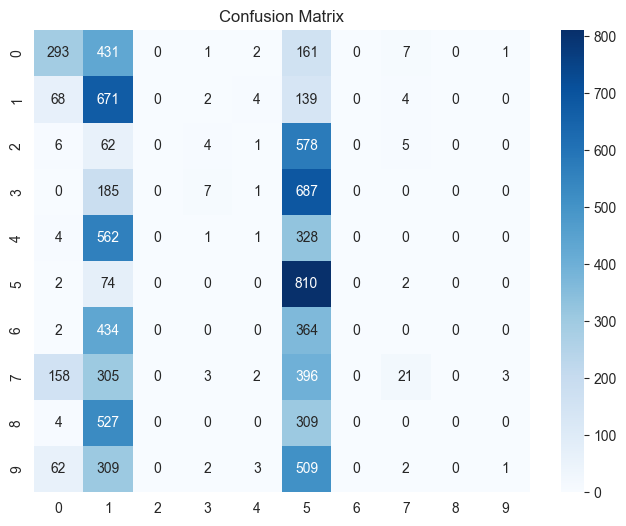

Accuracy:	0.21173708920187792
Precision:	0.20869674284606546
Recall:	0.21173708920187792
F1 score:	0.11211548002940487


C:\Users\Newowner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
hidden_layers=[128,64,32,16]
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)
activation = 'sig'

NN_sigmoid_4layers=ANN(X_train.shape[1],10, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation)
# TO-DO call train
training_time= NN_sigmoid_4layers.do_train(X_train,y_train)

# TO-DO call test
acc, pre,recall,f1 =NN_sigmoid_4layers.test(X_test, y_test)

# Saving the training results
res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time
}
# Append the results to the model_results list
model_results.append(res)

In [15]:
pd.DataFrame(model_results)

,activation,hidden_layer,accuracy,precision,recall,f1_score,training_time
0,sigmoid,multi_perceptron,0.342371,0.438607,0.342371,0.333687,40.487535
1,sig,"[128, 64]",0.356925,0.365800,0.356925,0.323141,31.466910
2,sig,"[256, 128]",0.377582,0.404105,0.377582,0.352192,83.164853
3,relu,"[128, 64]",0.558803,0.566918,0.558803,0.558430,27.720701
4,relu,"[128, 64, 32, 16]",0.553052,0.561859,0.553052,0.553385,30.601185
5,relu,"[256, 128, 64, 32]",0.610094,0.621387,0.610094,0.612217,81.834252
6,sig,"[128, 64, 32, 16]",0.211737,0.208697,0.211737,0.112115,36.075540


(1) Compare to the sigmoid activation function, with the same hidden layer structure of [128,64], relu yield a much better result, at **0.559** accuracy and **0.558** F1 score. On top of that, if we increase the number of hidden layers, the model will potentially be able to capture more complex structure and improve results. With 4 hidden layers at [256,128,64,32], the model can achieve **0.61** on both accuracy and F1 score, and with [512,128,64,32] layers, the result can be around *0.65* (omitted to reduce notebook's overall training time). Relu also avoid the **gradient vanishing** issue demonstrated by the sigmoid neural net with 4 hidden layers [128,64,32,16], which does not learn at all right from the first iteration

(2) Compare to the sigmoid activation function, relu while **converge slowly** after the initial 20 iterations but can still continued afterward, and does not necessarily come to an abrupt halt such as sigmoid.

(3) In this neural network, I applied **Xavier initialization** and  **Learning Rate Scheduler**, with a batch size at 512 images per batch similar to the sigmoid neural network. While the model also employ a **momentum** mechanism for the learning rate, applying this on top of the learning rate scheduler does not necessarily improve the training result so I set the momentum = 0 by default.  
 

In [24]:
import pandas as pd

# Read the CSV files into DataFrames, with the first row as column titles
train_df = pd.read_csv('my_emotion_train.csv')
test_df = pd.read_csv('my_emotion_test.csv')

In [32]:
train_pixel_columns = train_df['pixels'].str.split(' ', expand=True)
test_pixel_columns = test_df['pixels'].str.split(' ', expand=True)

In [33]:
# Concatenate the original DataFrame with the new pixel columns
train_concat = pd.concat([train_df[['id', 'emotion']], train_pixel_columns], axis=1)
# Concatenate the original DataFrame with the new pixel columns
test_concat = pd.concat([train_df[['id', 'emotion']], test_pixel_columns], axis=1)

In [39]:
train_concat

,id,emotion,0,1,2,3,4,5,6,7,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,9415,6,29,16,18,18,18,20,19,18,...,136,135,133,142,147,156,141,156,147,146
1,19109,3,126,154,167,181,188,194,195,194,...,84,75,66,57,56,55,55,54,50,47
2,21523,2,169,220,218,208,184,144,72,73,...,66,125,149,160,217,229,178,162,147,150
3,2076,3,60,64,72,80,83,83,80,82,...,211,216,217,216,215,216,217,217,219,218
4,13957,3,174,148,121,97,78,70,62,57,...,70,67,58,123,212,205,207,208,208,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28995,7926,5,54,49,35,32,27,32,39,41,...,173,214,165,111,111,117,116,99,87,115
28996,21200,3,101,107,111,90,95,129,134,139,...,86,186,188,186,188,185,181,176,163,140
28997,1097,3,133,113,120,151,178,199,209,215,...,159,162,86,39,23,69,126,141,129,60
28998,4186,3,65,63,63,54,58,58,49,54,...,21,23,19,52,97,60,24,31,41,55


In [63]:
# Split pixel values from the 'pixels' column, assuming the pixel values are space-separated
data_1d = train_df['pixels'].str.split(' ', expand=True).values.astype(np.uint8)

In [96]:
data_test_1d = test_df['pixels'].str.split(' ', expand=True).values.astype(np.uint8)

In [ ]:
# Add new columns to the DataFrame for each element in the array
for i in range(data_2d.shape[1]):
    for j in range(data_2d.shape[2]):
        df_train[f'Pixel_{i}_{j}'] = data_2d[:, i, j]

In [89]:
X_train = data_1d/255

In [90]:
# Splitting the data
y_train=np.asarray(train_df['emotion'])

## Apply One-hot encoding 
num_classes=np.max(y_train) +1
y_train_encoded=np.eye(num_classes)[y_train]

In [80]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23200, 2304)
X_test shape: (5800, 2304)
y_train shape: (23200,)
y_test shape: (5800,)


In [93]:
hidden_layers=[512,128,64,32]
max_iterations=100
learning_rate=0.1
activation='relu'
momentum=0 # With this set to 0, we essentially not using momentum in the current code
decay_factor = 0.8 # How much the learning rate will be reduce by after every decay_interval 
decay_interval = 5   # The interval after which the learning rate will be reduce  
lr_scheduler = LearningRateScheduler(learning_rate, decay_factor, decay_interval)
batch_size = 128
NN_relu_4layers=ANN(X_train.shape[1],7, 
                hidden_layers=hidden_layers, max_iterations=max_iterations, 
                learning_rate=learning_rate, momentum=momentum,
                lr_scheduler= lr_scheduler,activation=activation,
                    batch_size=batch_size)
# TO-DO call train
training_time = NN_relu_4layers.do_train(X_train, y_train)

Iteration: 5/100, Loss: 1.6522, Learning Rate: 0.08000000000000002
Iteration: 10/100, Loss: 1.5835, Learning Rate: 0.06400000000000002
Iteration: 15/100, Loss: 1.5305, Learning Rate: 0.051200000000000016
Iteration: 20/100, Loss: 1.4138, Learning Rate: 0.04096000000000002
Iteration: 25/100, Loss: 1.3425, Learning Rate: 0.03276800000000001
Iteration: 30/100, Loss: 1.2533, Learning Rate: 0.026214400000000013
Iteration: 35/100, Loss: 1.2695, Learning Rate: 0.02097152000000001
Iteration: 40/100, Loss: 1.1323, Learning Rate: 0.016777216000000008
Iteration: 45/100, Loss: 1.0316, Learning Rate: 0.013421772800000007
Iteration: 50/100, Loss: 0.9881, Learning Rate: 0.010737418240000006
Iteration: 55/100, Loss: 0.8638, Learning Rate: 0.008589934592000005
Iteration: 60/100, Loss: 0.8768, Learning Rate: 0.0068719476736000045
Iteration: 65/100, Loss: 0.7032, Learning Rate: 0.005497558138880004
Iteration: 70/100, Loss: 0.6682, Learning Rate: 0.004398046511104004
Iteration: 75/100, Loss: 0.5984, Learni

In [95]:
test_concat

,id,emotion,0,1,2,3,4,5,6,7,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,9415,6,123,109,128,142,103,113,145,179,...,78,68,102,144,164,123,11,6,6,2
1,19109,3,41,41,41,41,42,42,42,45,...,89,78,34,33,29,27,23,21,19,18
2,21523,2,248,228,211,197,194,181,195,180,...,221,224,232,238,236,236,237,243,253,255
3,2076,3,158,181,192,200,193,179,133,167,...,40,21,13,19,69,109,101,82,79,111
4,13957,3,195,185,166,165,149,98,89,83,...,177,171,193,189,196,195,195,193,196,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28995,7926,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28996,21200,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28997,1097,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28998,4186,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
NN_relu_4layers.do_predict(data_test_1d)
pred=NN_relu_4layers.activations[-1]
pred_labels=np.argmax(pred, axis=1) 

In [106]:
pred

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.00000000e+000, 0.00000000e+000, 6.44970740e-175],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 6.31523381e-111],
       [0.00000000e+000, 0.00000000e+000, 5.29236922e-073, ...,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       ...,
       [3.04777714e-074, 0.00000000e+000, 2.77098812e-313, ...,
        1.01133442e-266, 0.00000000e+000, 2.45955741e-074],
       [0.00000000e+000, 0.00000000e+000, 5.08117923e-264, ...,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [108]:
test_df['prediction'] = pred_labels

In [111]:
test_prediction = test_df.drop('pixels', axis=1)

In [112]:
test_prediction.to_csv('test_pred.csv')

In [ ]:
# TO-DO call test
acc, pre,recall,f1 = NN_relu_4layers.test(X_test, y_test)

# Saving the training results
res = {"activation": activation,
    "hidden_layer": hidden_layers, 
    "accuracy": acc,
    "precision": pre,
    "recall": recall,
    "f1_score": f1,
       'training_time':training_time}